#Análisis Factorial Exploratorio (AFE) y Confirmatorio (AFC) de variables procedentes de la Encuesta de Condiciones de Vida (ECV) con R

## Librerías:
Al usar R en Google Colab debemos:
1.   Instalar los paquetes/librerías (**install.packages("paquete")**) una vez cada vez que abramos el cuaderno de nuevo. Algunos paquetes ya  instalados por defecto en Colab, por lo que debemos pasar directamente al siguiente paso.
2.   Llamar a los paquetes/librerías (**library(paquete)**) una vez cada vez que abramos el cuaderno de nuevo - y tras haberlos instalado.

In [ ]:
install.packages("caret") #Para llevar a cabo la división de la muestra en dos mitades mediante muestreo de las observaciones
library(caret)
install.packages("psych") #Para realizar el AFE, el Análisis Paralelo y otras operaciones como el test de Mardia o el KMO
library(psych)
install.packages("ggcorrplot") #Para graficar las correlaciones obtenidas mediante un mapa de calor
library(ggcorrplot)
install.packages("GPArotation") #Para poder rotar los factores
library(GPArotation)
install.packages("lavaan") #Para realizar el AFC
library(lavaan)

## Datos:
Los datos que vamos a utilizar en este cuaderno proceden de la Encuesta de Condiciones de Vida (ECV) del año 2013. Dichos datos pueden descargarse de la siguiente página web:

https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176807&menu=resultados&idp=1254735976608#!tabs-1254736195153

En concreto vamos a utilizar el Fichero P (fichero de datos detallados de los adultos (*esudb13p*)), para analizar la estructura factorial de la siguiente batería de preguntas relacionadas con el bienestar:

*¿Cuál es su grado de satisfacción global con...*


1. *... su vida en la actualidad?* (variable PW010).
2. *... la situación económica en su hogar?* (PW030).
4. *... su vivienda?* (PW040).
5. *... su trabajo actual?* (PW100).
6. *... el tiempo que dispone para hacer lo que le gusta?* (PW120).
11. *... sus relaciones personales?* (PW160).
12. *... las áreas recreativas o verdes de la zona en la que vive?* (PW200).
14. *... la calidad de la zona en la que vive?* (PW210).


En todos los casos la escala de respuesta va del 0 (*Nada satisfecho*) al 10 (*Plenamente satisfecho*).



Para subir un archivo de datos (por ejemplo, un .csv) a Google Colab y trabajar con R debemos hacer lo siguiente:

1. Clicamos en el icono de la derecha de la pantalla que tiene forma de carpeta y se abre un desplegable a su derecha.
2. Clicamos en el icono que nos muestra una carpeta con una flecha hacia arriba en su interior.
3. Se abrirá una carpeta para que busquemos el archivo. Una vez seleccionado, le damos a "Abrir".
4. Esperamos a que se cargue y, una vez cargado, ya podemos usar la función de R apropiada para leer dicho archivo.

(Esta operación hay de carga hay que realizarla cada vez que se abra el cuaderno)

In [ ]:
datos <- read.csv("esudb13p.csv", sep=",")
#Este csv esta separado por ; y los decimales son ,
dim(datos)
head(datos)

[1] 26883   241

,PB010,PB020,PB030,PB040,PB040_F,PB100,PB100_F,PB110,PB110_F,PB120,⋯,PD050,PD050_F,PD060,PD060_F,PD070,PD070_F,PD080,PD080_F,PD090,PD090_F
,<int>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2013,ES,101,1525.7721,1,6,1,2013,1,33,⋯,1,1,1,1,1,1,1,1,6,1
2,2013,ES,102,1525.7721,1,6,1,2013,1,33,⋯,1,1,1,1,1,1,1,1,1,1
3,2013,ES,103,1525.7721,1,6,1,2013,1,26,⋯,1,1,3,1,1,1,1,1,6,1
4,2013,ES,201,913.0472,1,6,1,2013,1,NA,⋯,1,1,1,1,1,1,1,1,5,1
5,2013,ES,202,883.5042,1,6,1,2013,1,23,⋯,1,1,1,1,1,1,1,1,5,1
6,2013,ES,301,1164.4614,1,7,1,2013,1,37,⋯,2,1,2,1,2,1,2,1,2,1


In [ ]:
#PB030 identificador único de la persona
datos <- datos[, c("PB030", "PW010", "PW030", "PW040", "PW100", "PW120", "PW160", "PW200", "PW210")]
head(datos)

,PB030,PW010,PW030,PW040,PW100,PW120,PW160,PW200,PW210
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,101,8,8,8,8,8,8,8,8
2,102,8,8,8,NA,8,8,8,8
3,103,7,7,7,7,5,7,7,7
4,201,10,4,8,10,10,10,5,5
5,202,10,4,7,9,6,10,8,8
6,301,5,5,6,NA,8,8,8,7


Como vamos a hacer un doble Análisis Factorial - Exploratorio y Confirmatorio - vamos a dividir la muestra en aproximadamente el 50%, realizando el Exploratorio sobre una mitad, y el Confirmatorio sobre la otra, para ver si los resultados concuerdan.

In [ ]:
set.seed(2021) #Establecemos una semilla para facilitar la reproductibilidad de los resultados
subconjunto.ids <- createDataPartition(datos$PB030, p=0.5, list=F)
#Obtenemos mediante muestreo aleatorio el 50% de las observaciones (identificadas mediante la columna de ID del alumno)
datos_AFE <- datos[subconjunto.ids, ] #Para el Exploratorio solo conservamos las observaciones cuyos IDs han sido muestreados
dim(datos_AFE) #13443 observaciones
datos_AFC <- datos[-subconjunto.ids, ] #Para el COnfirmatorio solo conservamos las observaciones cuyos IDs no han sido muestreados
dim(datos_AFC) #13440 observaciones
#Eliminamos la columna de IDs, ya que no nos hace falta:
datos_AFE$PB030 <- NULL
datos_AFC$PB030 <- NULL

[1] 13443     9

[1] 13440     9

## Análisis Factorial Exploratorio (AFE):
El Análisis Factorial Exploratorio (AFE) es un método para reducir la dimensionalidad de un conjunto de variables/indicadores, es decir, es un método para resumir la información. En este sentido, puede confundirse con el Análisis de Componentes Principales (ACP).

El ACP parte de la varianza total para encontrar combinaciones lineales entre las variables originales que expliquen la mayor parte de dicha varianza total. Así, el primer componente principal sería aquella combinación lineal de variables que explica un mayor porcentaje de varianza total; el segundo componente principal sería aquel que explica la mayor proporción de varianza no explicada por el primero, y así sucesivamente.Al aplicar ACP a un conjunto de datos conseguimos pues resumir la información en unas pocas componentes principales. Dichas componentes principales, al ser combinaciones lineales de variables, resultan, muchas veces, difíciles de interpretar.

Por su parte, el AFE distingue entre varianza común y varianza específica. La varianza común o compartida es aquella parte de la variabilidad total de los datos que está compartida entre las variables; mientras, la varianza no compartida es la específica de cada variable. Los factores comunes son, por tanto, variables subyacentes - no observadas - que explican la asociación entre las variables.

Asimismo, desde el punto de vista de las variables, decimos que la comunalidad de una variable es la parte de su varianza explicada por los factores comunes. Por ello, interesa que este dato sea alto. Por el contrario, la especificidad es la parte de variabilidad de una variable específica de dicha variable. Esta última conviene pues que sea baja.

Los factores sí suelen tener una interpretación más sencilla que los componentes principales. Asimismo, mientras los componentes principales, por definición, no están correlacionados, los factores pueden estarlo.

El AFE suele utilizarse con datos procendentes de encuestas sociales, psicológicas o sanitarias, sin embargo, también puede aplicarse a otros tipos de datos. En nuestro caso tenemos datos procedentes de una encuesta de carácter sociodemográfico.


###Paso 1: Estimación de la matriz de correlaciones.
Dependiendo del tipo de datos que tengamos, debemos utilizar un tipo de correlación u otro:
* Datos continuos: La matriz de correlaciones de Pearson y la de Spearman son las más apropiadas ante continuos o ante datos ordinales (categóricos) con más de 7 categorías de respuesta (tienden a la continuidad).
* Datos categóricos/ordinales: la matriz de correlaciones policórica es la más recomendada ante datos ordinales de 7 o menos categorías de respuesta. Si tuviéramos datos dicotómicos, la matriz a emplear sería la matriz tetracórica (similar a la policórica pero con datos dicotómicos).

En nuestro caso, como tenemos datos ordinales con 11 opciones de respuesta (del 0 al 10), usaremos la matriz de correlaciones de Pearson.

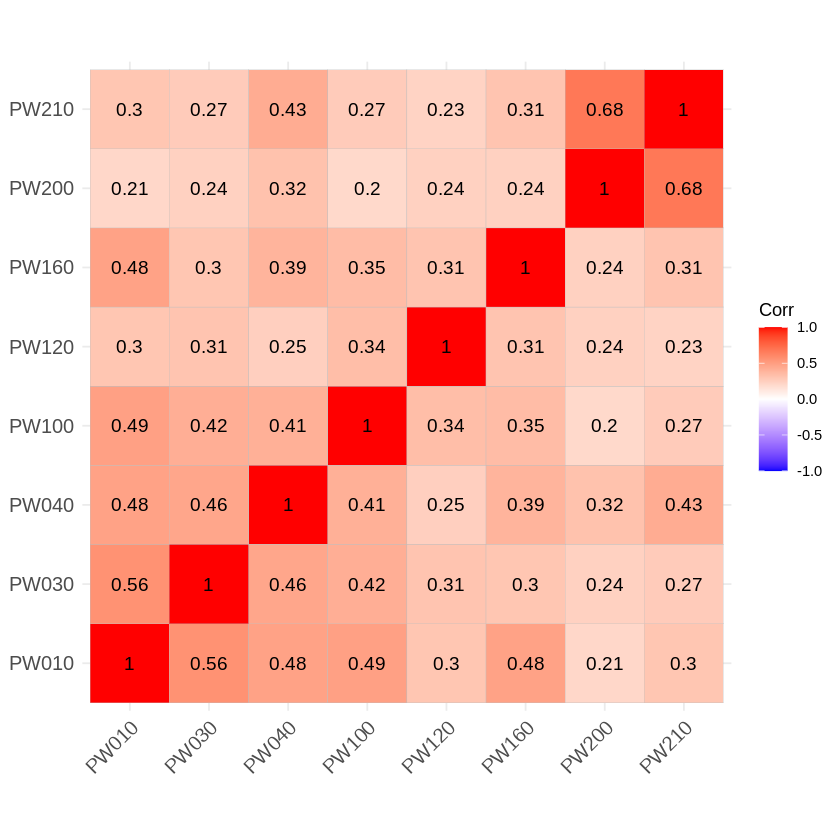

In [ ]:
matriz_correlaciones <- cor(datos_AFE, method = "pearson", use="complete.obs")
ggcorrplot(matriz_correlaciones, lab=T)

Todas las correlaciones son positivas y, en general, no son muy altas.

### Paso 2: Verificar que la matriz sea factorizable (es decir, que tiene sentido hacer un AFE con nuestros datos):
(Si la matriz no fuese factorizable, la relación entre las variables sería tan baja que no se formarían factores).

Entre los métodos para comprobar si la matriz es factorizable destacan:
* Test de esfericidad de Bartlett: se pregunta si la matriz de correlaciones es o no la matriz identidad. Si la matriz de correlaciones es la matriz identidad, las variables no estarían correlacionadas y no habría varianza compartida de la que extraer los factores (no habría factores comunes). Si rechazamos la hipótesis nula (la matriz de correlaciones es la matriz identidad), la matriz será factorizable.
* Medida KMO (Kaiser-Meyer-Olkin): expresa el grado de predicción de las variables a partir de las demás. Su valor oscila entre 0 y 1. Cuanto mayor sea, mejor. Valores a partir de 0,5 se consideran aceptables.
* Calcular el determinante de la matriz de correlaciones: valores cercanos a cero indican que la matriz es factorizable.

In [ ]:
#Test de esfericidad de Bartlett:
p_esf <- cortest.bartlett(matriz_correlaciones, n=nrow(datos_AFE))
cat("El p-valor del test de esfiricidad de Bartlett es: ", p_esf$p.value)
#KMO:
KMO(matriz_correlaciones)
#Determinante de la matriz:
cat("El valor del determinante de la matriz es: ", det(matriz_correlaciones))

El p-valor del test de esfiricidad de Bartlett es:  0

Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = matriz_correlaciones)
Overall MSA =  0.8
MSA for each item = 
PW010 PW030 PW040 PW100 PW120 PW160 PW200 PW210 
 0.81  0.83  0.88  0.89  0.88  0.86  0.67  0.70 

El valor del determinante de la matriz es:  0.08410902

1. El p-valor es menor a los niveles de significación habituales(10%, 5% y 1%) por lo que rechazamos la hipótesis nula: la matriz de correlaciones no es la matriz identidad.
2. El resultado del KMO es bueno: 0,80.
3. El determinante tiene un valor bastante bajo.

Los test muestran que la matriz es factorizable.

### Paso 3: determinar un método de extracción de factores:
La ecuación del modelo factorial es la siguiente:

\begin{align}
X_j = a_{j1}F_1 + a_{j2}F_2
+ ... +a_{jn}F_n + u_j
\end{align}

Donde $X_j$ (variable j) es una combinación lineal de factores comunes y del factor único (especificidad). Los $a_{jh}$ son los pesos factoriales, que representan la importancia que cada factor común tiene en explicar la variable $X_j$.

El objetivo de los métodos de extracción de factores es reproducir, con el mínimo error, la matriz de correlaciones a partir de la matriz de pesos factoriales.

Existen varios métodos de extracción de factores. Los más comunes son:
*   Máxima Verosimilitud (*Maximum Likelihood*, ML). Para utilizarlo, nuestros datos deben seguir una normal multivariante (lo que podemos comprobar realizando el test de Mardia, por ejemplo). Estadísticamente es el más adecuado, pues es asintóticamente insesgado, eficiente y consistente.
*   Mínimos Cuadrados No Ponderados (*Unweighted Least Squares*, ULS) (También llamado Residuos Mínimos, MinRes). No requiere de la existencia de normalidad multivariante.
* Ejes principales. Tampoco requiere de datos que sigan una normal multivariante.
* Componentes principales. Como hemos dicho en la introducción, no es método de ánalisis factorial propiamente dicho, ya que su objetivo es intentar explicar toda la varianza, y no solo la varianza común o compartida. Sin embargo, su uso, aunque no se recomiende, está bastante extendido, pues es la opción por defecto de muchos programas estadísticos.

Call: mardia(x = datos_AFE, na.rm = TRUE)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 5157   num.vars =  8 
b1p =  11.34   skew =  9750.3  with probability  <=  0
 small sample skew =  9757.24  with probability <=  0
b2p =  130.3   kurtosis =  142.78  with probability <=  0

Warning message in ks.test(datos_AFE, pnorm):
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  datos_AFE
D = 0.95804, p-value < 2.2e-16
alternative hypothesis: two-sided


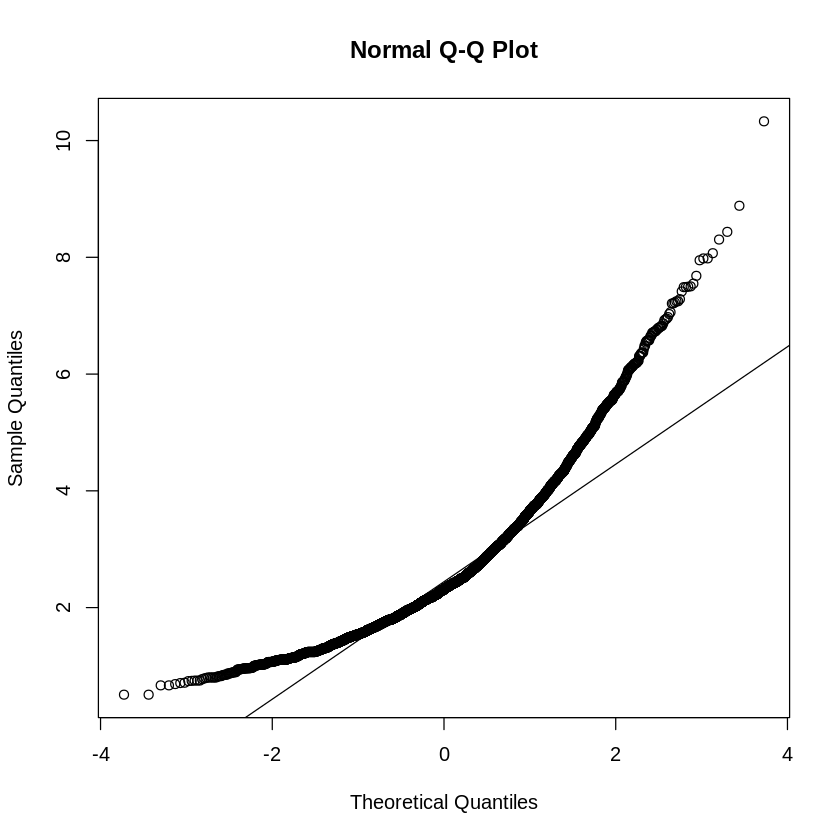

In [ ]:
#Test de Mardia:
mardia(datos_AFE, na.rm = TRUE)
ks.test(datos_AFE, pnorm)

Como los p-valores son inferiores a los niveles de significación habituales (10%, 5% y 1%) se rechaza la hipótesis nula, es decir, se rechaza la normalidad de los datos.

También podemos comprobar este hecho haciendo uso del Q-Q plot, ya que la línea de puntos está bastante alejada de la recta que refleja la normal.

Como no existe normalidad, debemos emplear un método de extracción de factores robusto la inexistencia de la misma, como es ULS (Mínimos Cuadrados No Ponderados).

### Paso 4: Determinamos el número de factores a extraer:
Existen cuatro métodos principales:
* Regla de Kaiser: se deben aceptar todos aquellos factores con un autovalor mayor a 1.
* Gráfico de sedimentación (*scree plot*): gráfico donde podemos ver cómo disminuye la varianza explicada o el autovalor a medida que vamos aumentando el número de factores a extraer. Se complementa muy bien con la regla de Kaiser.
* Establecimiento de un porcentaje de varianza explicada mínimo (por ejemplo, el 75%): cogeríamos todos los factores necesarios para explicar ese porcentaje mínimo de varianza.
* Análisis paralelo (AP, método recomendado): el AP parte de generar nuevas muestras aleatorias (mínimo 100) con el mismo número de variables y observaciones que la muestra original y, a partir de ello, se queda con aquellos factores cuyo autovalor es superior a los generados por azar.

Emplearemos el Análisis Paralelo al ser el método más recomendado.

Parallel analysis suggests that the number of factors =  4  and the number of components =  NA 


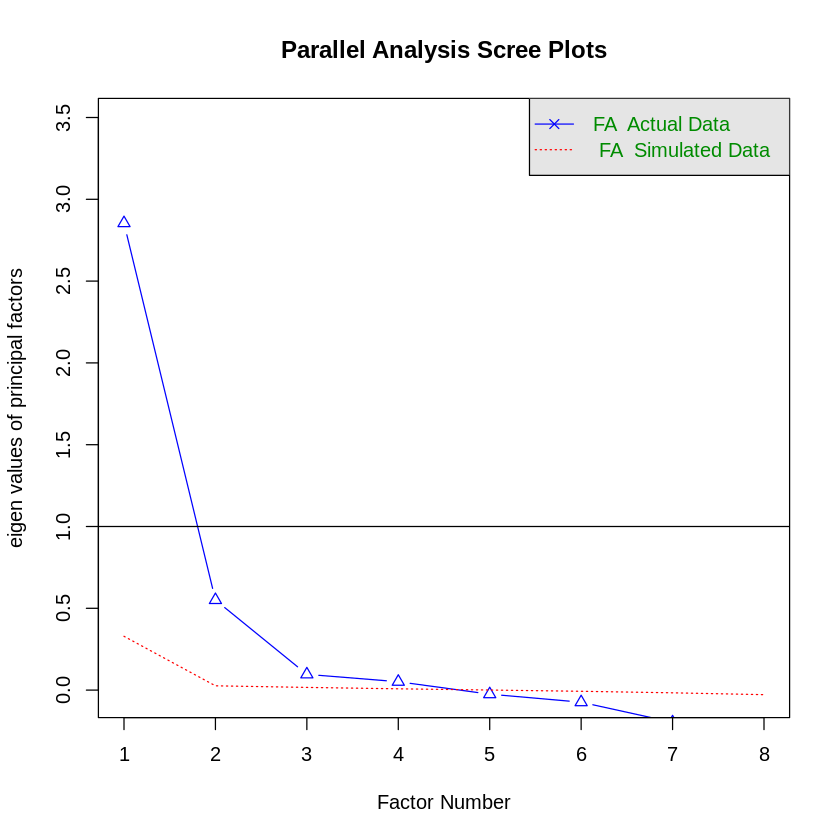

In [ ]:
fa.parallel(matriz_correlaciones, n.obs=nrow(datos_AFE), n.iter=500, fa="fa", fm="uls")

El Análisis Paralelo sugiere la extracción de 4 factores.

### Paso 5: Extracción de factores + rotación:
Vamos a extraer tres factores, siguiendo lo recomendado por el Análisis Paralelo.

Asimismo, debemos decidir si vamos a rotar los factores y qué tipo de rotación vamos a emplear. Los métodos de rotación facilitan la interpretación de los factores, ya que sin rotarlos, suele ser muy difíciles de interpretar, por lo que se recomienda el uso de dichas técnicas de rotación.

Existen dos tipos de rotación:
* Rotación oblicua: permite que los factores puedan tener correlación entre ellos. Tipo recomendado, ya que es el más cercano a la estructura real que deseamos explorar. Un ejemplo es el método *oblimin*.
* Rotación ortogonal: fuerza a los factores a que no puedan tener correlación entre ellos. Un ejemplo es el método *varimax*.

Probaremos los dos y nos quedaremos con la solución que mejor resultado arroje. Pero, ¿cómo determinamos qué solución factorial ajusta mejor?
* Fijándonos en los pesos factoriales: Cuanto mayor sea el peso factorial de un ítem en un factor mejor. Se aceptan pesos factoriales por encima de 0,4. En general, una buena solución presentará variables que pesan mucho en un factor y poco en el resto.
* Índices de bondad del ajuste. Existen unos cuantos, pero nos podemos fijar en RMSEA, SRMR, TLI y CFI. RMSEA y SRMR cuantos más bajos mejor (se aceptan valores por debajo de 0,08), y TLI y CFI cuantos más altos mejor (valores por encima de 0,95 se consideran muy buenos).

Factor Analysis using method =  uls
Call: fa(r = matriz_correlaciones, nfactors = 4, n.obs = nrow(datos_AFE), 
    rotate = "oblimin", fm = "uls", alpha = 0.05)
Standardized loadings (pattern matrix) based upon correlation matrix
       ULS1  ULS2  ULS4  ULS3   h2     u2 com
PW010  0.77 -0.06  0.09 -0.02 0.65 0.3543 1.0
PW030  0.01  0.01  0.98  0.01 1.00 0.0045 1.0
PW040  0.49  0.22  0.09 -0.03 0.44 0.5587 1.5
PW100  0.52  0.01  0.06  0.10 0.38 0.6242 1.1
PW120  0.01  0.00  0.01  0.99 1.00 0.0045 1.0
PW160  0.64  0.07 -0.14  0.07 0.39 0.6099 1.2
PW200 -0.07  0.74  0.05  0.06 0.55 0.4544 1.0
PW210  0.04  0.92 -0.02 -0.03 0.87 0.1317 1.0

                      ULS1 ULS2 ULS4 ULS3
SS loadings           1.63 1.51 1.07 1.05
Proportion Var        0.20 0.19 0.13 0.13
Cumulative Var        0.20 0.39 0.53 0.66
Proportion Explained  0.31 0.29 0.20 0.20
Cumulative Proportion 0.31 0.60 0.80 1.00

 With factor correlations of 
     ULS1 ULS2 ULS4 ULS3
ULS1 1.00 0.44 0.62 0.40
ULS2 0.44 1.00 0.28 0.

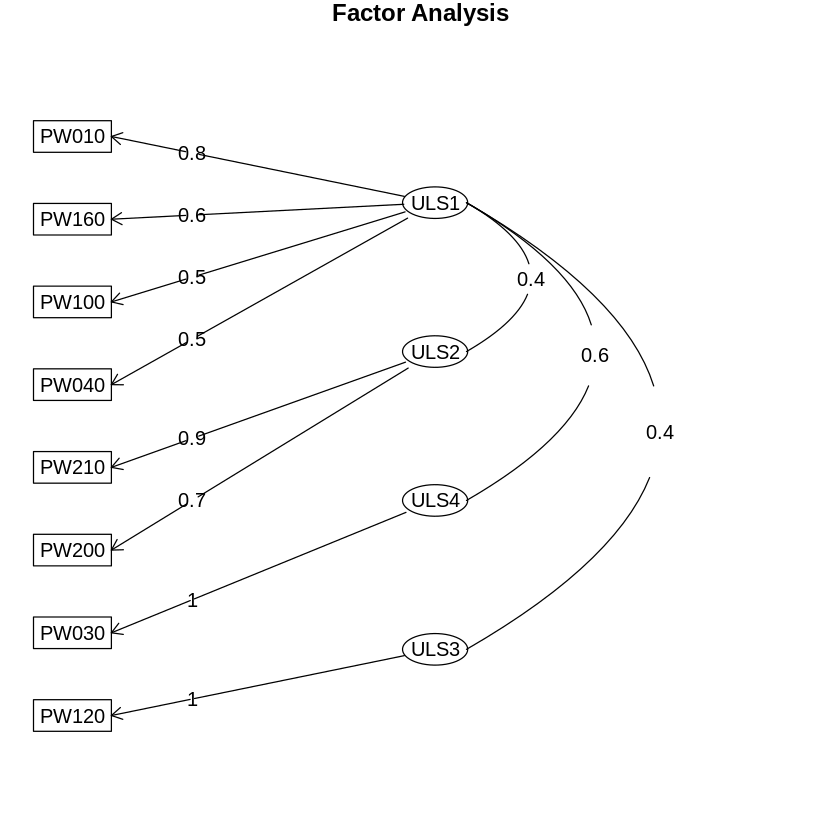

In [ ]:
#Rotación oblicua oblimin:
AFE_oblimin <- fa(matriz_correlaciones, nfactors=4, n.obs=nrow(datos_AFE), rotate="oblimin", fm="uls", alpha=0.05)
AFE_oblimin
fa.diagram(AFE_oblimin)

Factor Analysis using method =  uls
Call: fa(r = matriz_correlaciones, nfactors = 4, n.obs = nrow(datos_AFE), 
    rotate = "varimax", fm = "uls", alpha = 0.05)
Standardized loadings (pattern matrix) based upon correlation matrix
      ULS1 ULS2 ULS4 ULS3   h2     u2 com
PW010 0.74 0.10 0.27 0.09 0.65 0.3543 1.3
PW030 0.39 0.13 0.90 0.11 1.00 0.0045 1.4
PW040 0.54 0.31 0.22 0.06 0.44 0.5587 2.0
PW100 0.54 0.13 0.19 0.17 0.38 0.6242 1.6
PW120 0.25 0.13 0.10 0.95 1.00 0.0045 1.2
PW160 0.58 0.18 0.04 0.14 0.39 0.6099 1.3
PW200 0.15 0.71 0.09 0.11 0.55 0.4544 1.2
PW210 0.25 0.89 0.06 0.05 0.87 0.1317 1.2

                      ULS1 ULS2 ULS4 ULS3
SS loadings           1.77 1.49 1.00 1.00
Proportion Var        0.22 0.19 0.12 0.12
Cumulative Var        0.22 0.41 0.53 0.66
Proportion Explained  0.34 0.28 0.19 0.19
Cumulative Proportion 0.34 0.62 0.81 1.00

Mean item complexity =  1.4
Test of the hypothesis that 4 factors are sufficient.

The degrees of freedom for the null model are  28  and 

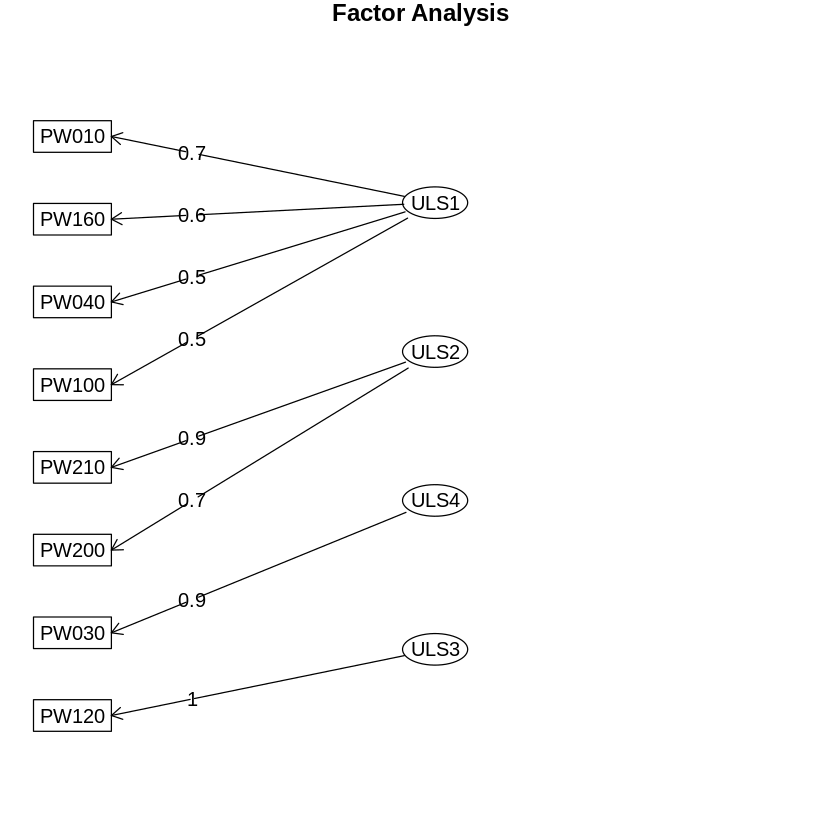

In [ ]:
#Rotación ortogonal varimax:
AFE_varimax <- fa(matriz_correlaciones, nfactors=4, n.obs=nrow(datos_AFE), rotate="varimax", fm="uls", alpha=0.05)
AFE_varimax
fa.diagram(AFE_varimax)

### Resultados AFE:
El resultado usando tanto la rotación oblicua como la ortogonal es similar (en la ortogonal vemos como los factores ya no están correlacionados - porque no se les permite estarlo). En ambos casos, el ajuste, siguiendo los índices de bondad del mismo, es muy bueno: RMSEA y RMSR inferiores a 0,08 y TLI mayor a 0,95.

## Análisis Factorial Confirmatorio (AFC):
La diferencia fundamental entre el AFE y el AFC, es que el AFE, como su propio nombre indica, es una técnica exploratoria: con ella queremos conocer la estructura de factores o variables latentes subyacente a los datos. Sin embargo, con el AFC, nosotros testamos si una determinada estructura factorial ajusta bien o no a los datos. Esto es, en este segundo caso, nosotros debemos imponer una estructura fatorial de antemano. Recurriendo a los índices de bondad del ajusto comprobaremos si dicha estructura es o no correcta.


### Paso 1: determinar un método de extracción de factores:
Al igual que hacíamos con el AFE, con el AFC también debemos determinar un método concreto para extraer los factores. Con el fin de establecer un método u otro, llevaremos a cabo un test de Mardia: si existiera normalidad multivariante, podríamos utilizar Máxima Verosimilitud. Si nuestros datos no fuesen normales, Mínimo Cuadrados No Ponderados sería una buena opción. 

Call: mardia(x = datos_AFC, na.rm = TRUE)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 5107   num.vars =  8 
b1p =  11.59   skew =  9861.08  with probability  <=  0
 small sample skew =  9868.16  with probability <=  0
b2p =  126.63   kurtosis =  131.71  with probability <=  0

Warning message in ks.test(datos_AFC, pnorm):
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  datos_AFC
D = 0.95624, p-value < 2.2e-16
alternative hypothesis: two-sided


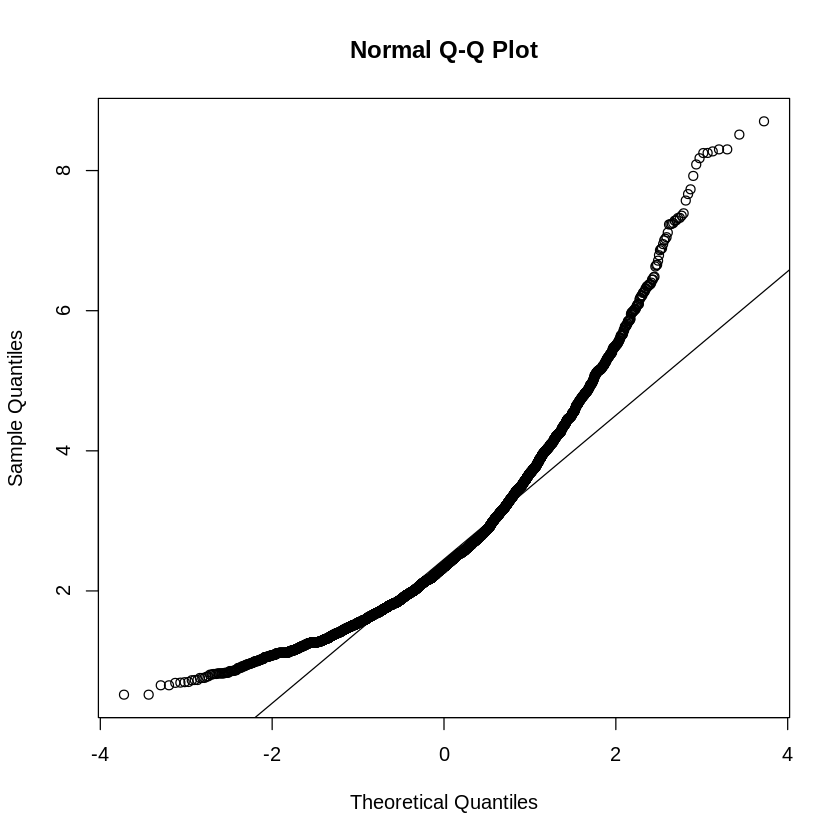

In [ ]:
mardia(datos_AFC, na.rm = TRUE)
ks.test(datos_AFC, pnorm)

Como podíamos esperar los resultados son idénticos a los obtenidos con la mitad de la muestra destinada al AFE: rechazamos la hipótesis nula de normalidad multivariante (al ser los p-valores inferiores a los niveles de significación habituales). Por ello, tampoco podemos usar Máxima Verosimilitud para el AFC, y usaremos, de nuevo, Mínimos Cuadrados No Ponderados (ULS).

### Paso 2: Probar una o varias estructuras factoriales:
Vamos a plantear 3 modelos diferentes: uno que replique la estructura factorial planteada en el AFE, otro de un solo factor y otro de dos factores.

Para comparar modelos nos vamos a fijar en los índices de bondad del ajuste. Al igual que comentamos con el AFE: la situación óptima es aquella en la que los índices SRMR y RMSEA son inferiores a 0,08 - cuanto más bajos mejor -, y los índices TLI y CFI son superiores a 0,95 - cuanto más altos mejor.

### Modelo con los cuatro factores que muestra el Exploratorio:

In [ ]:
#Especificamos el modelo:
modelo_4F_AFE <- 'Factor1 =~ PW010 + PW040 + PW100 + PW160
                  Factor2 =~ PW200 + PW210
                  Factor3 =~ PW120
                  Factor4 =~ PW030'
#Realizamos el factorial:
factorial_4F_AFE <- cfa(modelo_4F_AFE, datos_AFC, estimator="ULS", orthogonal=FALSE)
summary(factorial_4F_AFE, fit.measures=TRUE, standardized=TRUE)

lavaan 0.6-9 ended normally after 31 iterations

  Estimator                                        ULS
  Optimization method                           NLMINB
  Number of model parameters                        20
                                                      
                                                  Used       Total
  Number of observations                          5107       13440
                                                                  
Model Test User Model:
                                                      
  Test statistic                              2798.941
  Degrees of freedom                                16
  P-value (Unknown)                                 NA

Model Test Baseline Model:

  Test statistic                            244573.959
  Degrees of freedom                                28
  P-value                                           NA

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.989
  

Se nos despliega una gran cantidad de información, pero, para facilitar el análisis, nos fijaremos simplemente en los índices de bondad del ajuste. Siguiendo dichos índices, el ajuste parece bueno: SRMR < 0,08, y TLI y CFI > 0,95. Sin embargo, RMSEA es mayor a 0,8

### Modelo con un solo factor:

In [ ]:
#Planteamos el modelo:
modelo_1F <- 'Factor =~ PW010 + PW030 + PW040 + PW100 + PW120 + PW160 + PW200 + PW210'
#Realizamos el factorial:
factorial_1F_AFE <- cfa(modelo_1F, datos_AFC, estimator="ULS", orthogonal=FALSE)
summary(factorial_1F_AFE, fit.measures=TRUE, standardized=TRUE)

lavaan 0.6-9 ended normally after 35 iterations

  Estimator                                        ULS
  Optimization method                           NLMINB
  Number of model parameters                        16
                                                      
                                                  Used       Total
  Number of observations                          5107       13440
                                                                  
Model Test User Model:
                                                       
  Test statistic                              19921.783
  Degrees of freedom                                 20
  P-value (Unknown)                                  NA

Model Test Baseline Model:

  Test statistic                            244573.959
  Degrees of freedom                                28
  P-value                                           NA

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.91

Los índices de bondad del ajuste presentan todos peores valores que el modelo de 4 factores obtenido en el AFE: RMSEA = 0,441; SRMR = 0,084; CFI = 0,919; TLI = 0,886

### Modelo con dos factores:
Planteamos un modelo con dos factores: uno que englobe los tres items relacionados con la vivienda, y otro que englobe el resto de ítems.

In [ ]:
#Planteamos el modelo:
modelo_2F <- 'factor_vivienda =~ PW040 + PW200 + PW210
              factor_miscelanea =~ PW010 + PW030 + PW100 + PW120 + PW160'
#Realizamos el factorial:
factorial_2F <- cfa(modelo_2F, datos_AFC, estimator="ULS", orthogonal=FALSE)
summary(factorial_2F, fit.measures=TRUE, standardized=TRUE)

lavaan 0.6-9 ended normally after 35 iterations

  Estimator                                        ULS
  Optimization method                           NLMINB
  Number of model parameters                        17
                                                      
                                                  Used       Total
  Number of observations                          5107       13440
                                                                  
Model Test User Model:
                                                       
  Test statistic                              12204.349
  Degrees of freedom                                 19
  P-value (Unknown)                                  NA

Model Test Baseline Model:

  Test statistic                            244573.959
  Degrees of freedom                                28
  P-value                                           NA

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.95

Los índices de bondad del ajuste presentan todos peores valores que el modelo de 4 factores obtenido en el AFE: RMSEA = 0,354; SRMR = 0,073; CFI = 0,950; TLI = 0,927

### Resultados AFC:
Los índices de bondad del ajuste muestran que, de los tres modelos planteados, el modelo que refleja la estructura de los cuatro factores del AFE es el que mejor ajuste tiene.

## Paso final Análisis Factorial: Interpretamos los factores obtenidos tanto con el AFE como con el AFC:
Intentamos darle nombre a los factores, facilitando la interpretación de los resultados.

Los resultados entre el Análisis Factorial Exploratorio (AFE) y el Confirmatorio (AFC) concuerdan: el modelo que mejor ajusta es el que tiene cuatro factores:

* Factor 1: variables PW010 (grado de satisfacción con la vida en la actualidad), PW040 (grado de satisfacción con la vivienda), PW100 (grado de satisfacción con el trabajo actual) y PW160 (grado de satisfacción con las relaciones personales). Factor "bienestar general/principal".
* Factor 2: variables PW200 (grado de satisfacción con las áreas recreativas o verdes de la zona en la que vive) y PW210 (grado de satisfacción con la calidad de la zona en la que vive).  Factor "zona residencial".
* Factor 3: variable PW120 (grado de satisfacción con el tiempo que dispone para hacer lo que le gusta). Factor "tiempo libre".
* Factor 4: variable PW030 (grado de satisfacción con la situación económica en su hogar). Factor "situación económica".